# IPT

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import irbasis3

plt.rcParams.update({
    "font.family": "serif",
    "font.size": 16,
})

## Step 1: Generate IR basis and associated sampling points

In [2]:
beta = 10.0
wmax = 10.0
lambda_ = beta * wmax
eps = 1e-7

wmax = lambda_/beta
K = irbasis3.KernelFFlat(lambda_=lambda_)
basis = irbasis3.FiniteTempBasis(K, statistics="F", beta=beta, eps=eps)
L = basis.size

# Sparse sampling in tau
smpl_tau = irbasis3.TauSampling(basis)
ntau = smpl_tau.sampling_points.size
print("cond (tau): ", smpl_tau.cond)

# Sparse sampling in Matsubara frequencies
smpl_matsu = irbasis3.MatsubaraSampling(basis)
nw = smpl_matsu.sampling_points.size
print("cond (matsu): ", smpl_matsu.cond)

cond (tau):  5.818091568503528
cond (matsu):  9.63347101793072


## Step 2
Define a non-interacting DOS:
$$
\rho(\omega) = \frac{\sqrt{4-\omega^2}}{2\pi}.
$$

In [6]:
rho_omega = lambda omega: np.sqrt(4-omega**2) / (2 * np.pi)

from scipy.integrate import quad
assert np.abs(quad(rho_omega, -2, 2)[0] - 1) < 1e-9 # Check rule

$$
\begin{align*}
  G_\mathrm{loc}(\mathrm{i}\nu) &= \int \mathrm{d}\omega \frac{\rho(\omega)}{\mathrm{i}\nu - \omega - \Sigma(\mathrm{i}\nu)}\\
  \mathcal{G}(\mathrm{i}\nu) &= (G^{-1}(\mathrm{i}\nu) + \Sigma(\mathrm{i}\nu))^{-1}\\
  \Sigma(\tau) &= U^2 \mathcal{G}(\tau)^2 \mathcal{G}(\beta-\tau)
\end{align*}
$$

In [39]:
from numpy.polynomial.legendre import leggauss

def scale_quad(x, w, xmin, xmax):
    """ Scale weights and notes of quadrature to the interval [xmin, xmax] """
    assert xmin < xmax
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x + 1) + xmin
    return x_, w_

class IPTSolver:
    def __init__(self, U, basis, rho_omega, omega_range, deg_leggauss=1000):
        assert isinstance(omega_range, tuple)
        assert omega_range[0] < omega_range[1]
        self.U = U
        self.basis = basis
        self.beta = basis.beta
        self.rho_omega = rho_omega

        x_, w_ = leggauss(deg_leggauss)
        self._quad_rule = scale_quad(x_, w_, omega_range[0], omega_range[1])

        self._smpl_matsu = irbasis3.MatsubaraSampling(basis)
        self._smpl_tau = irbasis3.TauSampling(basis)

    def gloc_iv(self, sigma_iv):
        """
        Compute G_loc(iv) from Sigma_iv

        G_loc(iv) \simeq \sum_q w_q rho(x_q)/(iv - w_q - \Sigma(iv))
        """
        quad_points = self._quad_rule[0]
        quad_weight = self._quad_rule[1]
        iv = 1j * self._smpl_matsu.sampling_points * np.pi/self.beta
        r = np.einsum('q,q,wq->w',
            quad_weight,
            self.rho_omega(quad_points),
            1/((iv-sigma_iv)[:,None] - quad_points[None,:]),
            optimize=True
        )
        return r
    
    def g0_iv(self, gloc, sigma_iw):
        """
        Compute \mathcal{G}(iv) from G_loc(iv) and Sigma(iv)
        """
        return 1/(1/gloc + sigma_iw)
    
    def sigma_iv(self, g0_iv):
        """
        Compute Sigma(tau) from \mathcal{G}(iv)
        """
        g0_IR = self._smpl_matsu.fit(g0_iv, axis=0)
        g0_tau = self._smpl_tau.evaluate(g0_IR)
        sigma_tau = (self.U**2) * (g0_tau**2) * g0_tau[::-1]
        sigma_IR = self._smpl_tau.fit(sigma_tau)
        return self._smpl_matsu.evaluate(sigma_IR, axis=0)
    
    def new_sigma_iv(self, sigma_iv):
        gloc_iv = self.gloc_iv(sigma_iv)
        g0_iv = self.g0_iv(gloc_iv, sigma_iv)
        r = self.sigma_iv(g0_iv)
        return r


In [40]:
niter = 1000
mixing = 0.1

U = 1.0

# Initialize solver
solver = IPTSolver(U, basis, rho_omega, (-2,2))

sigma_iv = np.zeros_like(
    solver._smpl_matsu.sampling_points.size, dtype=np.complex128)


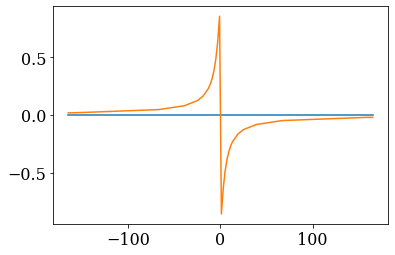

In [41]:
# Gloc_iv
gloc_iv = solver.gloc_iv(sigma_iv)
plt.plot(
    solver._smpl_matsu.sampling_points,
    gloc_iv.real
)
plt.plot(
    solver._smpl_matsu.sampling_points,
    gloc_iv.imag
)

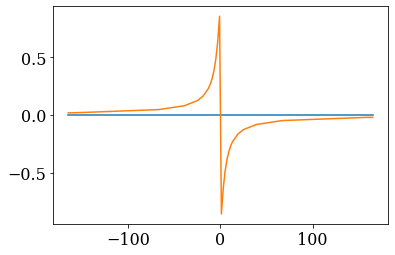

In [42]:
# Gloc_iv
g0_iv = solver.g0_iv(gloc_iv, sigma_iv)
plt.plot(
    solver._smpl_matsu.sampling_points,
    g0_iv.real
)
plt.plot(
    solver._smpl_matsu.sampling_points,
    g0_iv.imag
)

In [43]:
for iter in range(niter):
    new_sigma_iv = solver.new_sigma_iv(sigma_iv)
    print(iter, np.linalg.norm(new_sigma_iv - sigma_iv))
    sigma_iv = mixing * new_sigma_iv + (1-mixing) * sigma_iv

0 0.18925467964570708
1 0.17051460930767848
2 0.15363030571931338
3 0.13841799362274063
4 0.12471209612828942
5 0.11236343291874813
6 0.10123759677790668
7 0.0912134908080209
8 0.08218201044252936
9 0.07404485593040498
10 0.06671346238379573
11 0.06010803575630772
12 0.05415668426916129
13 0.04879463583885653
14 0.04396353299409513
15 0.03961079761159451
16 0.03568905855916743
17 0.03215563601822203
18 0.02897207687405719
19 0.026103736117639956
20 0.02351939970296279
21 0.021190944755015678
22 0.019093033429739403
23 0.01720283709348174
24 0.015499787819383852
25 0.0139653544954183
26 0.012582841106651518
27 0.011337204995651688
28 0.010214893122437277
29 0.009203694541285286
30 0.00829260748826166
31 0.007471719632401717
32 0.006732100186778385
33 0.0060657027048117125
34 0.00546527750352421
35 0.004924292760253409
36 0.004436863423761611
37 0.003997687165792127
38 0.0036019866757514398
39 0.003245457670274014
40 0.0029242220516619913
41 0.0026347857052305304
42 0.0023740004761241187

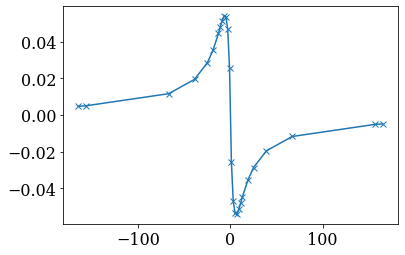

In [45]:
plt.plot(
    solver._smpl_matsu.sampling_points,
    sigma_iv.imag,
    marker="x"
)